In [9]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [2]:
CLASS_NAMES = ['glioma', 'meningioma', 'pituitary', 'notumor']
LABEL_MAP = {name: idx for idx, name in enumerate(CLASS_NAMES)}

In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for label_name in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label_name)
            if os.path.isdir(label_path):
                for file in os.listdir(label_path):
                    if file.endswith(('.jpg', '.png')):
                        self.samples.append((os.path.join(label_path, file), LABEL_MAP[label_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.18794892, 0.18794641, 0.18795056],
                        std=[0.18724446, 0.18724621, 0.18725474])
])

train_ds = BrainTumorDataset("../data/Training", transform=transform)
test_ds = BrainTumorDataset("../data/Testing", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0037622..4.2949624].


Batch shape: torch.Size([32, 3, 224, 224])


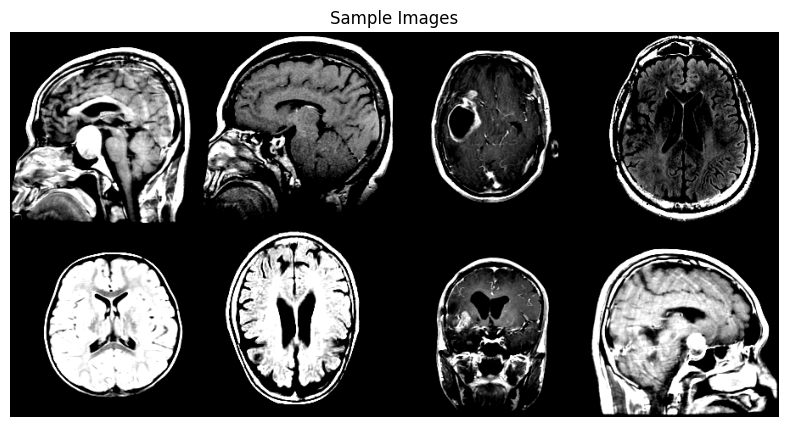

In [10]:
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)

grid = torchvision.utils.make_grid(images[:8], nrow=4)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.title("Sample Images")
plt.axis('off')
plt.show()

In [14]:
from torchvision.models import resnet18, ResNet18_Weights

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet18_Weights.DEFAULT

model = models.resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [20]:
for epoch in range(5):
    model.train()
    total_loss = 0

    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, lbls)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 39.9959
Epoch 2, Loss: 7.5314
Epoch 3, Loss: 3.7879
Epoch 4, Loss: 3.4194
Epoch 5, Loss: 2.6747


In [21]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)

print(f"Test Accuracy: {correct / total:.2%}")

Test Accuracy: 98.70%


In [22]:
torch.save(model.state_dict(), "../models/resnet18_brain_mri.pt")
print("Model saved!")

Model saved!
